# Tutorial 06

## template fitting pipeline pre-process

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
NSAMP = 10
APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200
FWHM = [(52.8/60.)*np.pi/180.,(19./60.)*np.pi/180.,(11./60.)*np.pi/180.,(4.94/60.)*np.pi/180.]

map23f = hp.read_map('./data/pysm_s1d1_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')
ell = np.arange(cmb_cl.shape[1])
mapcmb = np.empty((NSAMP+1,3,map23f.shape[1]),dtype=np.float32)
for i in range(NSAMP+1):
    mapcmb[i] = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)

vmap23 = hp.read_map('./data/wmapvar_23.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap23 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap23.shape[1]))*np.sqrt(vmap23)
nmap95 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap95.shape[1]))*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap150.shape[1]))*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=(NSAMP+1,3,vmap353.shape[1]))*np.sqrt(vmap353)

map23 = hp.smoothing(mapcmb[0]+map23f,fwhm=FWHM[0],verbose=0)+nmap23[0]
map95 = hp.smoothing(mapcmb[0]+map95f,fwhm=FWHM[1],verbose=0)+nmap95[0]
map150 = hp.smoothing(mapcmb[0]+map150f,fwhm=FWHM[2],verbose=0)+nmap150[0]
map353 = hp.smoothing(mapcmb[0]+map353f,fwhm=FWHM[3],verbose=0)+nmap353[0]

map23s = hp.smoothing(mapcmb[0]+map23f,fwhm=FWHM[0],verbose=0)
map353s = hp.smoothing(mapcmb[0]+map353f,fwhm=FWHM[3],verbose=0)

fullmap = dict()
fullmap[95] = map95
fullmap[150] = map150

fullnoise = dict()
fullnoise[95] = nmap95[1:]
fullnoise[150] = nmap150[1:]

fullfiducial = dict()
fullfiducial[95] = mapcmb[1:]
fullfiducial[150] = mapcmb[1:]

fullbeam = dict()
fullbeam[95] = FWHM[1]
fullbeam[150] = FWHM[2]

tmpmap = dict()
tmpmap[23] = map23
tmpmap[353] = map353

tmpnoise = dict()
tmpnoise[23] = nmap23[1:]
tmpnoise[353] = nmap353[1:]

tmpbeam = dict()
tmpbeam[23] = FWHM[0]
tmpbeam[353] = FWHM[3]

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### window function matrix (top-hat according to NaMaster)

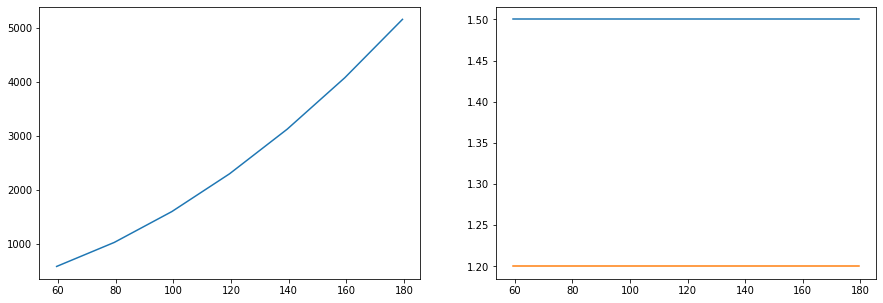

In [2]:
from afra.tools.ps_estimator import pstimator

est = pstimator(nside=NSIDE,mask=mask,aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,targets='EB')
window = est.bpconvert(np.ones(LMAX-LMIN))

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(est.modes,window)

filtee = np.identity(len(est.modes))
filtbb = np.identity(len(est.modes))
filteb = 0.5*np.identity(len(est.modes))
filtbe = 0.2*np.identity(len(est.modes))

est.filt = {'EB': np.c_[np.r_[filtee,filtbe],np.r_[filteb,filtbb]]}
filted_bp = est.filtrans(np.ones((2,len(est.modes))))

ax[1].plot(est.modes,filted_bp[0])
ax[1].plot(est.modes,filted_bp[1])

#### simple likelihood pre-process

- T mode

condition number:  9.853858674090697
CPU times: user 37.1 s, sys: 348 ms, total: 37.5 s
Wall time: 5.08 s


<AxesSubplot:>

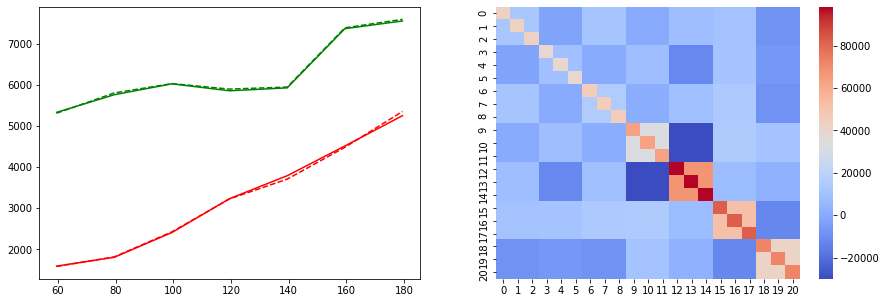

In [3]:
%%time

est.targets='T'
pipeline = af.tpfpipe(fullmap,noises=fullnoise,fiducials=fullfiducial,mask=mask,fwhms=fullbeam,
                      templates=tmpmap,template_noises=tmpnoise,template_fwhms=tmpbeam,
                      targets='T')
rslt_t = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

bp23s = est.autoBP(map23s,fwhms=FWHM[0])
bp353s = est.autoBP(map353s,fwhms=FWHM[3])

print ('condition number: ',np.linalg.cond(rslt_t[3]))

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(est.modes,pipeline.template_ps[23][0],'r')
ax[0].plot(est.modes,pipeline.template_ps[353][0],'g')
ax[0].plot(est.modes,bp23s[1],'r--')
ax[0].plot(est.modes,bp353s[1],'g--')

sns.heatmap(rslt_t[3],cmap='coolwarm',annot=False,ax=ax[1])

- E mode

condition number:  8.467049803652703
CPU times: user 15min 28s, sys: 2.64 s, total: 15min 31s
Wall time: 2min 4s


<AxesSubplot:>

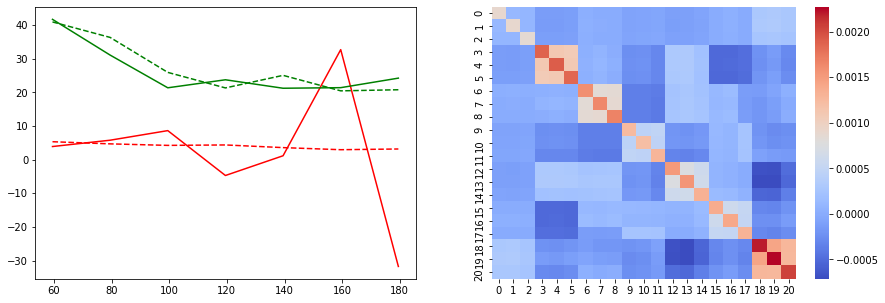

In [4]:
%%time

pipeline.targets='E'
est.targets='E'
rslt_t = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

bp23s = est.autoBP(map23s,fwhms=FWHM[0])
bp353s = est.autoBP(map353s,fwhms=FWHM[3])

print ('condition number: ',np.linalg.cond(rslt_t[3]))

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(est.modes,pipeline.template_ps[23][0],'r')
ax[0].plot(est.modes,pipeline.template_ps[353][0],'g')
ax[0].plot(est.modes,bp23s[1],'r--')
ax[0].plot(est.modes,bp353s[1],'g--')

sns.heatmap(rslt_t[3],cmap='coolwarm',annot=False,ax=ax[1])

- B mode

condition number:  8.467049803652703
CPU times: user 15min 27s, sys: 3.35 s, total: 15min 31s
Wall time: 2min 5s


<AxesSubplot:>

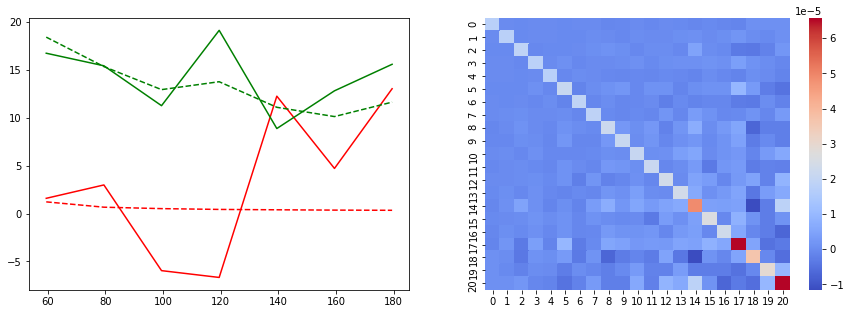

In [5]:
%%time

pipeline.targets='B'
est.targets='B'
rslt_b = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

bp23s = est.autoBP(map23s,fwhms=FWHM[0])
bp353s = est.autoBP(map353s,fwhms=FWHM[3])

print ('condition number: ',np.linalg.cond(rslt_t[3]))

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(est.modes,pipeline.template_ps[23][0],'r')
ax[0].plot(est.modes,pipeline.template_ps[353][0],'g')
ax[0].plot(est.modes,bp23s[1],'r--')
ax[0].plot(est.modes,bp353s[1],'g--')

sns.heatmap(rslt_b[3],cmap='coolwarm',annot=False,ax=ax[1])

- E & B modes

condition number:  8.467049803652703
CPU times: user 27min 17s, sys: 6.94 s, total: 27min 24s
Wall time: 3min 52s


<AxesSubplot:>

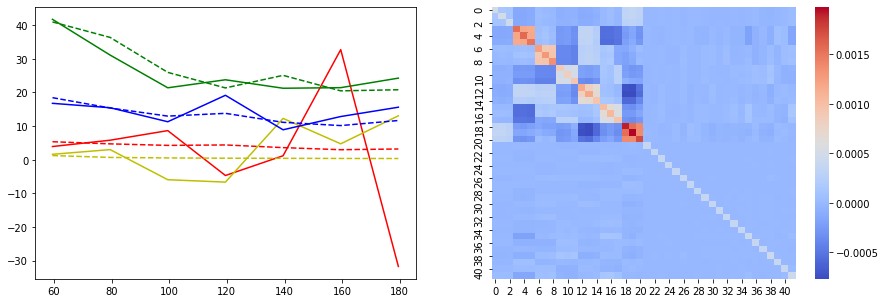

In [6]:
%%time

pipeline.targets = 'EB'
est.targets='EB'
rslt_b = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)

bp23s = est.autoBP(map23s,fwhms=FWHM[0])
bp353s = est.autoBP(map353s,fwhms=FWHM[3])

print ('condition number: ',np.linalg.cond(rslt_t[3]))

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(est.modes,pipeline.template_ps[23][0],'r')
ax[0].plot(est.modes,pipeline.template_ps[353][0],'g')
ax[0].plot(est.modes,bp23s[1],'r--')
ax[0].plot(est.modes,bp353s[1],'g--')

ax[0].plot(est.modes,pipeline.template_ps[23][1],'y')
ax[0].plot(est.modes,pipeline.template_ps[353][1],'b')
ax[0].plot(est.modes,bp23s[2],'y--')
ax[0].plot(est.modes,bp353s[2],'b--')

sns.heatmap(rslt_b[3],cmap='coolwarm',annot=False,ax=ax[1])

end